In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1


In [3]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

time: 457 µs (started: 2023-04-16 14:25:38 +00:00)


In [ ]:
#download a kaggle dataset that is already split into training, validation and test dataset
#with a ratio for 80/10/10 
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bhanuprasanna/isic-2019
!unzip /isic-2019.zip #change this code to the correct path name to unzip the dataset

In [7]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Set the random seed for reproducibility
torch.manual_seed(42)

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 3.95 ms (started: 2023-04-16 14:26:49 +00:00)


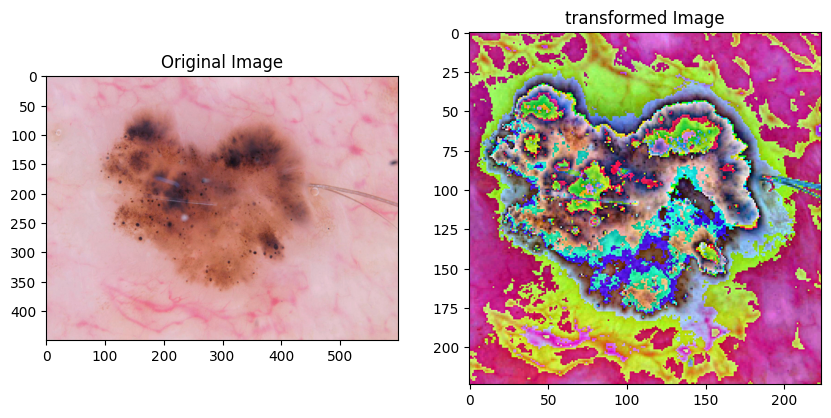

time: 366 ms (started: 2023-04-16 14:33:10 +00:00)


In [9]:
#show the image after applying transform, the picture looks distorted because we have applied normalization 
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image

image_path = '/ISIC - 2019/test/Basal cell carcinoma/ISIC_0027229.jpg'
input_image = Image.open(image_path)

# Apply the transforms function to the input image
auto_transformsimg = auto_transforms(input_image)

# Convert the tensor back to an image for visualization
auto_transformsimg = transforms.ToPILImage()(auto_transformsimg)

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(auto_transformsimg)
axs[1].set_title('transformed Image')
plt.show()

In [16]:
# loading and transforming the data

!pip install torchsampler

from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and transform the data
train_dataset = datasets.ImageFolder(root='/ISIC - 2019/train', transform=auto_transforms)
test_dataset = datasets.ImageFolder(root='/ISIC - 2019/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='/ISIC - 2019/val', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=4)

time: 1.6 s (started: 2023-04-16 14:35:01 +00:00)


In [ ]:
#we can see that the dataset is balanced in the dataloader batches distribution, this should handle the class imbalance problem. 

from collections import Counter

# Get the labels for the samples in the training dataset
train_labels = train_dataset.targets

# Use the Counter class from the collections module to count the number of samples in each class
class_counts = Counter(train_labels)

# Check the class distribution of the batches in train_dataloader
batch_class_counts = Counter()
for batch in train_dataloader:
    batch_labels = batch[1]
    batch_class_counts.update(batch_labels.tolist())

print("Class distribution in train_dataset:", class_counts)
print("Class distribution in train_dataloader batches:", batch_class_counts)


Class distribution in train_dataset: Counter({4: 10979, 5: 3812, 1: 2820, 2: 2215, 0: 716, 6: 541, 3: 206, 7: 202})
Class distribution in train_dataloader batches: Counter({3: 2732, 6: 2708, 7: 2703, 1: 2699, 5: 2675, 2: 2662, 4: 2657, 0: 2655})


In [17]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 3.99 ms (started: 2023-04-16 14:35:05 +00:00)


In [18]:
import timm 
import torch

#create the model and change number of classes to 8
model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Set the random seed for reproducibility
torch.manual_seed(42)

#freeze the weights
for param in model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in model.head.parameters():
    param.requires_grad = True

time: 1.26 s (started: 2023-04-16 14:35:07 +00:00)


In [19]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 386 ms (started: 2023-04-16 14:35:09 +00:00)


In [20]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning in notebook: MaxViT_thesiscode_no_data_aug.ipynb

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device agnostic code
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.002677105045743513)

time: 6.4 ms (started: 2023-04-16 14:35:13 +00:00)


In [21]:
#in this code we apply mixed precision training to allow for faster training and use early stopping to prevent overfitting 

# Set the random seed for reproducibility
torch.manual_seed(42)

import matplotlib.pyplot as plt
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()    # Scale the gradients
        scaler.step(optimizer)           # Update the model parameters
        scaler.update()                  # Update the scaler
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.1963, Train Acc: 0.5670, Val Loss: 1.2154, Val Acc: 0.5764
Epoch 2/20: Train Loss: 1.0113, Train Acc: 0.6412, Val Loss: 1.1616, Val Acc: 0.5895
Epoch 3/20: Train Loss: 0.9721, Train Acc: 0.6541, Val Loss: 1.1783, Val Acc: 0.5618
Epoch 4/20: Train Loss: 0.9342, Train Acc: 0.6667, Val Loss: 1.1274, Val Acc: 0.6063
Epoch 5/20: Train Loss: 0.9190, Train Acc: 0.6721, Val Loss: 1.2990, Val Acc: 0.5455
Epoch 6/20: Train Loss: 0.9068, Train Acc: 0.6793, Val Loss: 1.2771, Val Acc: 0.5482
Epoch 7/20: Train Loss: 0.8875, Train Acc: 0.6843, Val Loss: 1.2473, Val Acc: 0.5623
Epoch 8/20: Train Loss: 0.8999, Train Acc: 0.6802, Val Loss: 1.3036, Val Acc: 0.5628
Epoch 9/20: Train Loss: 0.8937, Train Acc: 0.6811, Val Loss: 1.2001, Val Acc: 0.5895
No improvement for 5 epochs, stopping training.
time: 19min 57s (started: 2023-04-16 14:35:13 +00:00)


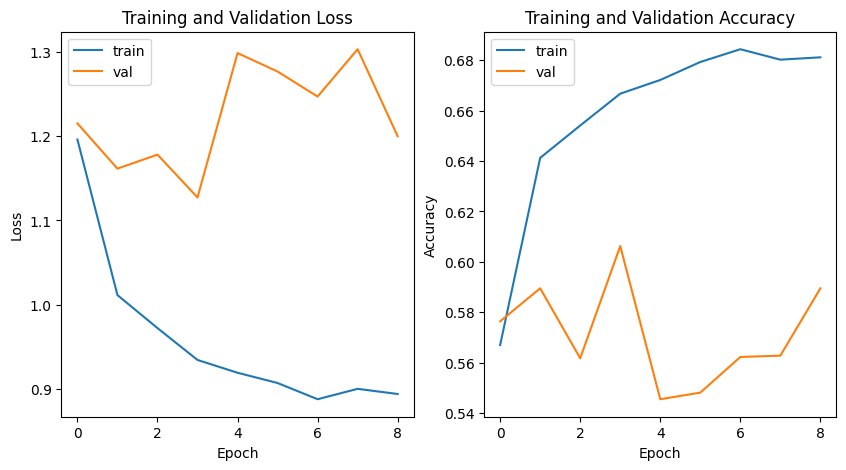

time: 236 ms (started: 2023-04-16 14:56:28 +00:00)


In [25]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [26]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.2141
Test Accuracy: 0.5798
Sensitivity: 0.5798
Specificity: 0.9056
ROC-AUC: 0.8508
F1-score: 0.4008
Classification Report:
              precision    recall  f1-score   support

           0     0.1869    0.4933    0.2711        75
           1     0.6423    0.3520    0.4548       250
           2     0.3800    0.3744    0.3772       203
           3     0.0309    0.2727    0.0556        11
           4     0.8502    0.7295    0.7853       965
           5     0.5951    0.4694    0.5248       360
           6     0.1871    0.6190    0.2873        42
           7     0.3404    0.6667    0.4507        24

    accuracy                         0.5798      1930
   macro avg     0.4016    0.4971    0.4008      1930
weighted avg     0.6750    0.5798    0.6118      1930

time: 41 s (started: 2023-04-16 14:56:37 +00:00)


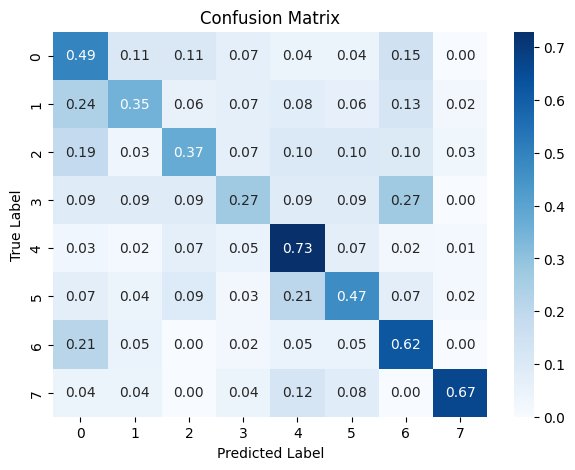

time: 220 ms (started: 2023-04-16 14:57:18 +00:00)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([str(i) for i in range(8)])
ax.yaxis.set_ticklabels([str(i) for i in range(8)])
plt.show()